# 나이브 베이즈 분류기 (Naive Bayes Classification)

* 베이즈 정리를 기반으로 하는 확률적 분류 알고리즘
* 모든 특성(feature)이 독립적이라는 베이즈 정리의 기본 가정 하에 작동하며, 텍스트 분류, 스팸 필터링, 감정 분석 등 다양한 분야에서 활용

### 나이브 베이즈 분류기의 종류

1. **가우시안 나이브 베이즈 (Gaussian Naive Bayes)**: 연속적인 데이터에 대해 가우시안(정규) 분포를 가정
2. **베르누이 나이브 베이즈 (Bernoulli Naive Bayes)**: 이진(0/1) 데이터에 적합하며, 텍스트 분류에서 단어의 존재 여부를 기반으로 작동
3. **다항 나이브 베이즈 (Multinomial Naive Bayes)**: 단어의 발생 빈도와 같은 정수형 데이터를 처리하는 데 사용

### 나이브 베이즈의 확률 모델

* 나이브 베이즈는 조건부 확률 모델로, 주어진 특성 벡터 \( x \)에 대해 \( k \)개의 가능한 클래스에 대한 확률을 출력

\begin{equation}
p(C_k|x) = \frac{p(C_k) \cdot p(x|C_k)}{p(x)}
\end{equation}

* 위 식에서 분모는 모든 클래스에 대해 동일하므로 예측에는 영향을 미치지 않는 상수값에 해당
* 따라서, 최종 예측은 다음과 같이 비례식으로 표현 가능

\begin{aligned}
p(C_k|x)&∝p(C_k)p(x|C_k)\\
&∝p(C_k,x_1,...,x_n)
\end{aligned}

* 최종적으로 연쇄 법칙을 사용해 아래와 같은 식으로 표현 가능

\begin{aligned}
p(C_k,x_1,...,x_n)&=p(C_k)p(x_1,...,x_n|C_k)\\
&=p(C_k)p(x_1|C_k)p(x_2,...,x_n|C_k,x_1)\\
&=p(C_k)p(x_1|C_k)p(x_2|C_k,x_1)p(x_3,...,x_n|C_k,x_1,x_2)\\
&=p(C_k)p(x_1|C_k)p(x_2|C_k,x_1)...p(x_n|C_k,x_1,x_2,...,x_n-1)
\end{aligned}

* 위 식을 통해 나온 값들 중 가장 큰 값을 갖는 클래스가 예측 결과에 해당

\begin{equation}
\hat{y} = \arg\max_k \ p(C_k) \prod_{i=1}^n p(x_i \mid C_k)
\end{equation}

## 나이브 베이즈 예제

In [1]:
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.datasets import fetch_20newsgroups, fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn import metrics

In [2]:
# 나이브 베이즈 분류기의 클래스별 사전 확률과 가능도를 사용하여 클래스 가능성 계산

# 각 클래스의 사전 확률 정의 (p(C_k) 부분)
prior = [0.45, 0.3, 0.15, 0.1]

# 각 클래스에 대한 가능도 정의 (p(x|C_k) 부분)
likelihood = [[0.3, 0.3, 0.4], [0.7, 0.2, 0.1], [0.15, 0.5, 0.35], [0.6, 0.2, 0.2]]

# 클래스 인덱스 초기화
idx = 0

# 각 클래스에 대해 사전 확률과 가능도를 사용하여 가능성 계산
for c, xs in zip(prior, likelihood):
    result = 1.  # 결과 초기화
    
    # 가능도의 각 요소를 곱함
    for x in xs:
        result *= x
    
    # 사전 확률을 곱함
    result *= c
    
    # 클래스 인덱스 증가
    idx += 1

    # 각 클래스의 계산된 가능성 출력
    print(f"{idx}번째 클래스의 가능성: {result}")

1번째 클래스의 가능성: 0.0162
2번째 클래스의 가능성: 0.0042
3번째 클래스의 가능성: 0.0039375
4번째 클래스의 가능성: 0.0024000000000000002


### 산림 토양 데이터
* 산림 지역 토양의 특징 데이터
* 토양이 어떤 종류에 속하는지 예측
* https://archive.ice.uci.edu/ml/datasets/Covertype 에 상세 설명 확인 가능

In [3]:
# 산림 토양 데이터셋 로드 및 정보 확인

# UCI 산림 토양 데이터셋 로드
covtype = fetch_covtype()

# 데이터셋에 대한 자세한 설명 출력
print(covtype.DESCR)

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

=================   ============
Classes                        7
Samples total             581012
Dimensionality                54
Features                     int
=================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target values in ``target``. If optional argument 'as_frame' is
se

In [4]:
# 산림 토양 데이터셋을 pandas DataFrame으로 변환하여 내용 확인

pd.DataFrame(covtype.data)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396.0,153.0,20.0,85.0,17.0,108.0,240.0,237.0,118.0,837.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581008,2391.0,152.0,19.0,67.0,12.0,95.0,240.0,237.0,119.0,845.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581009,2386.0,159.0,17.0,60.0,7.0,90.0,236.0,241.0,130.0,854.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581010,2384.0,170.0,15.0,60.0,5.0,90.0,230.0,245.0,143.0,864.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# 산림 토양 데이터셋의 타깃 레이블 확인

covtype.target

array([5, 5, 2, ..., 3, 3, 3], dtype=int32)

#### 학습, 평가 데이터 분류

In [6]:
# 산림 토양 데이터셋의 변수들을 X 변수로 설정, 타깃 레이블을 y 변수로 설정

covtype_X = covtype.data
covtype_y = covtype.target

In [7]:
# 산림 토양 데이터셋을 훈련 세트와 테스트 세트로 분할

covtype_X_train, covtype_X_test, covtype_y_train, covtype_y_test = train_test_split(covtype_X,covtype_y, test_size=0.2)

In [8]:
# 분할된 데이터셋 크기에 대한 분석

print('전체 데이터 크기: {}'.format(covtype_X.shape))
print('학습 데이터 크기: {}'.format(covtype_X_train.shape))
print('평가 데이터 크기: {}'.format(covtype_X_test.shape))

전체 데이터 크기: (581012, 54)
학습 데이터 크기: (464809, 54)
평가 데이터 크기: (116203, 54)


#### 전처리

##### 전처리 전 데이터

In [9]:
# 데이터 분할 검증을 위한 분할 전/후 데이터 비교 분석
# 데이터 분할 전 데이터의 기초 통계 정보 출력

covtype_df = pd.DataFrame(data=covtype_X)
covtype_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# 데이터 분할 후 학습 데이터의 기초 통계 정보 출력

covtype_train_df = pd.DataFrame(data=covtype_X_train)
covtype_train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,...,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000,464809.000000
mean,2959.315796,155.667636,14.109684,269.479857,46.419738,2348.186810,212.159915,223.304564,142.493228,1979.667500,...,0.044173,0.090749,0.077630,0.002702,0.003238,0.000198,0.000497,0.026753,0.023971,0.015053
std,280.147046,111.912147,7.489543,212.518768,58.272000,1559.714896,26.775440,19.758974,38.277059,1324.133354,...,0.205479,0.287252,0.267588,0.051912,0.056810,0.014067,0.022287,0.161361,0.152959,0.121766
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1103.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1994.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3164.000000,261.000000,18.000000,390.000000,69.000000,3326.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7116.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
# 데이터 분할 후 평가 데이터의 기초 통계 정보 출력

covtype_test_df = pd.DataFrame(data=covtype_X_test)
covtype_test_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,...,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000
mean,2959.563316,155.613495,14.079783,269.221655,46.415325,2357.985766,212.090583,223.375326,142.668399,1982.786116,...,0.044181,0.088965,0.078062,0.003055,0.003322,0.000232,0.000577,0.027004,0.022925,0.015086
std,279.335665,111.920487,7.483019,212.672453,58.388314,1557.395463,26.747716,19.807526,38.264254,1324.445365,...,0.205499,0.284694,0.268270,0.055188,0.057539,0.015241,0.024005,0.162097,0.149666,0.121894
min,1860.000000,0.000000,0.000000,0.000000,-159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2810.000000,58.000000,9.000000,108.000000,7.000000,1112.000000,198.000000,213.000000,119.000000,1025.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,2010.000000,218.000000,226.000000,143.000000,1714.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3336.000000,231.000000,237.000000,169.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3853.000000,360.000000,64.000000,1369.000000,598.000000,7117.000000,254.000000,254.000000,254.000000,7142.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### 전처리 과정

In [12]:
# 데이터의 스케일을 조정하기 위해 StandardScaler 객체 생성
scaler = StandardScaler()

# 훈련 데이터의 스케일을 조정하기 위해 StandardScaler를 적합(fit)하고 변환(transform)하여 표준화된 훈련 데이터를 생성
covtype_X_train_scale = scaler.fit_transform(covtype_X_train)

# 테스트 데이터의 스케일을 조정하기 위해, 훈련 데이터에서 학습한 스케일링 변환을 적용하여 표준화된 테스트 데이터를 생성
covtype_X_test_scale = scaler.transform(covtype_X_test)

##### 전처리 후 데이터
* 평균은 0에 가깝게, 표준편차는 1에 가깝게 정규화

In [13]:
# 표준화된 훈련 데이터를 pandas DataFrame으로 변환
covtype_train_df = pd.DataFrame(data=covtype_X_train_scale)

# 데이터프레임의 기초 통계 정보를 출력하여 특성의 요약 통계를 확인
covtype_train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,...,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05,4.648090e+05
mean,2.267104e-16,4.401061e-17,-2.753147e-17,2.549833e-17,-4.182460e-17,1.352267e-16,1.312828e-16,-2.278340e-16,7.600581e-17,-6.606941e-17,...,-8.910657e-17,-6.952422e-17,4.769472e-18,2.302187e-17,4.037235e-17,9.324928e-19,-1.177081e-17,-3.374554e-17,-4.952913e-17,-2.977862e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.927641e+00,-1.390982e+00,-1.883920e+00,-1.268030e+00,-3.765444e+00,-1.505525e+00,-7.923685e+00,-1.130144e+01,-3.722684e+00,-1.495068e+00,...,-2.149754e-01,-3.159216e-01,-2.901091e-01,-5.205292e-02,-5.699480e-02,-1.407018e-02,-2.229855e-02,-1.657960e-01,-1.567159e-01,-1.236267e-01
25%,-5.365609e-01,-8.727180e-01,-6.822431e-01,-7.598389e-01,-6.764789e-01,-7.983434e-01,-5.288402e-01,-5.215137e-01,-6.137685e-01,-7.217313e-01,...,-2.149754e-01,-3.159216e-01,-2.901091e-01,-5.205292e-02,-5.699480e-02,-1.407018e-02,-2.229855e-02,-1.657960e-01,-1.567159e-01,-1.236267e-01
50%,1.309464e-01,-2.561622e-01,-1.481646e-01,-2.422370e-01,-2.817778e-01,-2.270846e-01,2.181137e-01,1.364159e-01,1.323958e-02,-2.036561e-01,...,-2.149754e-01,-3.159216e-01,-2.901091e-01,-5.205292e-02,-5.699480e-02,-1.407018e-02,-2.229855e-02,-1.657960e-01,-1.567159e-01,-1.236267e-01
75%,7.306321e-01,9.412068e-01,5.194336e-01,5.671041e-01,3.874980e-01,6.269186e-01,7.036338e-01,6.931256e-01,6.663730e-01,4.307218e-01,...,-2.149754e-01,-3.159216e-01,-2.901091e-01,-5.205292e-02,-5.699480e-02,-1.407018e-02,-2.229855e-02,-1.657960e-01,-1.567159e-01,-1.236267e-01
max,3.207905e+00,1.825830e+00,6.928376e+00,5.305514e+00,9.517107e+00,3.056852e+00,1.562631e+00,1.553495e+00,2.913152e+00,3.922066e+00,...,4.651696e+00,3.165342e+00,3.446979e+00,1.921122e+01,1.754546e+01,7.107230e+01,4.484596e+01,6.031508e+00,6.380975e+00,8.088866e+00


In [14]:
# 표준화된 테스트 데이터를 pandas DataFrame으로 변환
covtype_test_df = pd.DataFrame(data=covtype_X_test_scale)

# 데이터프레임의 기초 통계 정보를 출력하여 테스트 데이터의 특성 요약 통계를 확인
covtype_test_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,...,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000,116203.000000
mean,0.000884,-0.000484,-0.003992,-0.001215,-0.000076,0.006283,-0.002589,0.003581,0.004576,0.002355,...,0.000040,-0.006211,0.001614,0.006796,0.001477,0.002447,0.003571,0.001559,-0.006837,0.000264
std,0.997105,1.000076,0.999130,1.000724,1.001997,0.998514,0.998966,1.002458,0.999667,1.000237,...,1.000094,0.991097,1.002548,1.063097,1.012832,1.083455,1.077072,1.004565,0.978472,1.001056
min,-3.924071,-1.390982,-1.883920,-1.268030,-3.525191,-1.505525,-7.923685,-11.301437,-3.722684,-1.495068,...,-0.214975,-0.315922,-0.290109,-0.052053,-0.056995,-0.014070,-0.022299,-0.165796,-0.156716,-0.123627
25%,-0.532991,-0.872718,-0.682243,-0.759839,-0.676479,-0.792573,-0.528840,-0.521514,-0.613769,-0.720976,...,-0.214975,-0.315922,-0.290109,-0.052053,-0.056995,-0.014070,-0.022299,-0.165796,-0.156716,-0.123627
50%,0.130946,-0.256162,-0.148165,-0.242237,-0.281778,-0.216826,0.218114,0.136416,0.013240,-0.200635,...,-0.214975,-0.315922,-0.290109,-0.052053,-0.056995,-0.014070,-0.022299,-0.165796,-0.156716,-0.123627
75%,0.727063,0.932271,0.519434,0.538871,0.387498,0.633330,0.703634,0.693126,0.692498,0.430722,...,-0.214975,-0.315922,-0.290109,-0.052053,-0.056995,-0.014070,-0.022299,-0.165796,-0.156716,-0.123627
max,3.190057,1.825830,6.661337,5.173761,9.465624,3.057494,1.562631,1.553495,2.913152,3.898654,...,4.651696,3.165342,3.446979,19.211217,17.545461,71.072299,44.845960,6.031508,6.380975,8.088866


### 20 Newsgroup 데이터
* 뉴스 기사가 어느 그룹에 속하는지 분류
* 뉴스 기사는 텍스트 데이터이기 때문에 특별한 전처리 과정이 필요

In [15]:
# 20개의 뉴스 그룹 데이터셋을 로드
newsgroup = fetch_20newsgroups()

# 데이터셋에 대한 설명 출력
print(newsgroup.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

=================   ==========
Classes                     20
Samples total            18846
Dimensionality               1

In [16]:
# 데이터셋 출력

newsgroup.data

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 

In [17]:
# 타깃 레이블인 뉴스 그룹 출력

newsgroup.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

#### 학습 평가 데이터 분류

In [18]:
# 뉴스 그룹 데이터 자체적으로 분리해둔 학습 및 평가 데이터셋 로드

newsgroup_train = fetch_20newsgroups(subset='train')
newsgroup_test = fetch_20newsgroups(subset='test')

In [19]:
# 학습 및 평가 데이터셋에 대한 타깃 레이블(그룹) 제외 X 변수로 설정 및 타깃 레이블을 y 변수로 설정

X_train, y_train = newsgroup_train.data, newsgroup_train.target
X_test, y_test = newsgroup_test.data, newsgroup_test.target

#### 벡터화
* 텍스트 데이터는 기계학습 모델에 입력 할 수 없음
* 벡터화는 텍스트 데이터를 실수 벡터로 변환해 기계학습 모델에 입력 할 수 있도록 하는 전처리 과정
* Scikit-learn에서는 Count, Tf-idf, Hashing 세가지 방법을 지원

##### CountVectorizer
* 문서에 나온 단어의 수를 단순 갯수를 기반으로 벡터 생성

In [20]:
# CountVectorizer를 활용해 X 변수들에대한 벡터화 진행

count_vectorizer = CountVectorizer()

X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

+ train set에서만 fit_transform을 사용하는 이유
* fit_transform은 데이터의 기존 평균과 분산을 고려하여 이를 0과 1로 scaling해주는 메서드에 해당
* 결론적으로, 이 과정에서 0과 1의 평균과 분산을 갖는 데이터를 학습해 test set에서도 well-performing 하는 모델을 만드는 것이 목표
* 만약 test set에서도 fit_transform을 사용할 경우 모델이 test_set 또한 학습하게 되는 악효과가 발생할 수 있음

In [21]:
# 벡터화된 학습 데이터의 일부를 출력하여 벡터화 결과를 확인
X_train_count

<11314x130107 sparse matrix of type '<class 'numpy.int64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [22]:
# 벡터화된 첫 번째 문서(0)의 단어(*) 빈도(n)를 출력 "(0, *)  n"
for v in X_train_count[0]:
    print(v)

  (np.int32(0), np.int32(56979))	3
  (np.int32(0), np.int32(75358))	2
  (np.int32(0), np.int32(123162))	2
  (np.int32(0), np.int32(118280))	2
  (np.int32(0), np.int32(50527))	2
  (np.int32(0), np.int32(124031))	2
  (np.int32(0), np.int32(85354))	1
  (np.int32(0), np.int32(114688))	1
  (np.int32(0), np.int32(111322))	1
  (np.int32(0), np.int32(123984))	1
  (np.int32(0), np.int32(37780))	5
  (np.int32(0), np.int32(68532))	3
  (np.int32(0), np.int32(114731))	5
  (np.int32(0), np.int32(87620))	1
  (np.int32(0), np.int32(95162))	1
  (np.int32(0), np.int32(64095))	1
  (np.int32(0), np.int32(98949))	1
  (np.int32(0), np.int32(90379))	1
  (np.int32(0), np.int32(118983))	1
  (np.int32(0), np.int32(89362))	3
  (np.int32(0), np.int32(79666))	1
  (np.int32(0), np.int32(40998))	1
  (np.int32(0), np.int32(92081))	1
  (np.int32(0), np.int32(76032))	1
  (np.int32(0), np.int32(4605))	1
  :	:
  (np.int32(0), np.int32(37565))	1
  (np.int32(0), np.int32(113986))	1
  (np.int32(0), np.int32(83256))	1
  (np.

##### HashingVectorizer
* 각 단어를 해쉬 값으로 표현
* 미리 정해진 크기의 벡터로 표현

In [23]:
# HashingVectorizer를 사용하여 문서 데이터 벡터화
# 'n_features=1000'은 벡터화된 결과의 차원 수를 1000으로 제한

hash_vectorizer = HashingVectorizer(n_features=1000)

In [24]:
# 학습 및 평가 데이터에 대해 HashingVectorizer를 적용하여 변환

X_train_hash = hash_vectorizer.fit_transform(X_train)
X_test_hash = hash_vectorizer.transform(X_test)

In [25]:
# 벡터화된 학습 데이터의 일부를 출력하여 벡터화 결과 확인

X_train_hash

<11314x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1550687 stored elements in Compressed Sparse Row format>

In [26]:
# 벡터화된 첫 번째 문서(0)의 해시(*) 빈도(n - 해시화 과정으로 인해 특정 값에 대한 음 양의 값을 가짐)를 출력 "(0, *)  n"

for v in X_train_hash[0]:
    print(v)

  (np.int32(0), np.int32(80))	-0.0642824346533225
  (np.int32(0), np.int32(108))	0.0642824346533225
  (np.int32(0), np.int32(111))	-0.128564869306645
  (np.int32(0), np.int32(145))	0.0642824346533225
  (np.int32(0), np.int32(158))	0.0642824346533225
  (np.int32(0), np.int32(159))	-0.0642824346533225
  (np.int32(0), np.int32(161))	0.0642824346533225
  (np.int32(0), np.int32(165))	-0.0642824346533225
  (np.int32(0), np.int32(171))	0.0642824346533225
  (np.int32(0), np.int32(182))	0.0642824346533225
  (np.int32(0), np.int32(195))	-0.0642824346533225
  (np.int32(0), np.int32(196))	0.19284730395996752
  (np.int32(0), np.int32(205))	-0.0642824346533225
  (np.int32(0), np.int32(209))	0.0642824346533225
  (np.int32(0), np.int32(234))	0.0642824346533225
  (np.int32(0), np.int32(237))	0.0642824346533225
  (np.int32(0), np.int32(248))	0.0642824346533225
  (np.int32(0), np.int32(265))	0.19284730395996752
  (np.int32(0), np.int32(274))	0.0642824346533225
  (np.int32(0), np.int32(277))	0.19284730395

##### TfidfVectorizer
* 문서에 나온 단어 빈도(term frequency)와 역문서 빈도(inverse document frequency)를 곱해서 구함
* 각 빈도는 일반적으로 로그 스케일링 후 사용
* $tf(t, d) = log(f(t, d) + 1)$
* $idf(t, D) = \frac{|D|}{|d \in D : t \in d| + 1}$
* $tfidf(t, d, D) = tf(t, d) \times idf(t, D)$

In [27]:
# 단어 빈도(TF)와 역문서 빈도(IDF)를 결합하여 단어의 중요도 평가

tfidf_vectorizer = TfidfVectorizer()

In [28]:
# 학습 및 평가 데이터에 대해 TFIDFVectorizer를 적용하여 변환

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [29]:
# 벡터화된 학습 데이터의 일부를 출력하여 벡터화 결과 확인

X_train_tfidf

<11314x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [30]:
# 벡터화된 첫 번째 문서(0)의 등장 단어(*)에 대한 TF-IDF 값(n) 출력 "(0, *) n"
# TF-IDF 값 - 각 단어의 중요도에 따라 결정된 값

for v in X_train_tfidf[0]:
    print(v)

  (np.int32(0), np.int32(56979))	0.0574701540748513
  (np.int32(0), np.int32(75358))	0.3538350134970617
  (np.int32(0), np.int32(123162))	0.25970902457356887
  (np.int32(0), np.int32(118280))	0.21186807208281694
  (np.int32(0), np.int32(50527))	0.05461428658858725
  (np.int32(0), np.int32(124031))	0.10798795154169123
  (np.int32(0), np.int32(85354))	0.03696978508816317
  (np.int32(0), np.int32(114688))	0.06214070986309587
  (np.int32(0), np.int32(111322))	0.019156718024950434
  (np.int32(0), np.int32(123984))	0.036854292634593756
  (np.int32(0), np.int32(37780))	0.3813389125949312
  (np.int32(0), np.int32(68532))	0.07325812342131598
  (np.int32(0), np.int32(114731))	0.1444727551278406
  (np.int32(0), np.int32(87620))	0.0356718631408158
  (np.int32(0), np.int32(95162))	0.03447138409326312
  (np.int32(0), np.int32(64095))	0.035420924271313554
  (np.int32(0), np.int32(98949))	0.16068606055394935
  (np.int32(0), np.int32(90379))	0.01992885995664587
  (np.int32(0), np.int32(118983))	0.03708

#### 가우시안 나이브 베이즈

* 입력 특성이 가우시안(정규) 분포를 갖는다고 가정

In [31]:
# Gaussian Naive Bayes 모델 생성 및 스케일링 된 학습 데이터를 활용한 학습 진행

model = GaussianNB()
model.fit(covtype_X_train_scale, covtype_y_train)

GaussianNB()

In [32]:
# 학습 데이터에 대한 예측 수행
predict = model.predict(covtype_X_train_scale)

# 학습 데이터에 대한 정확도(Accuracy) 및 F1 스코어 계산
acc = metrics.accuracy_score(covtype_y_train, predict)
f1 = metrics.f1_score(covtype_y_train, predict, average=None)

print('Train Accuracy: {}'.format(acc))
print('Train F1 score: {}'.format(f1))

Train Accuracy: 0.08843847687975061
Train F1 score: [0.04056189 0.01813697 0.33709701 0.13695693 0.04361231 0.06992784
 0.23709473]


In [33]:
# 평가 데이터에 대한 예측 수행
predict = model.predict(covtype_X_test_scale)

# 평가 데이터에 대한 정확도(Accuracy) 및 F1 스코어 계산
acc = metrics.accuracy_score(covtype_y_test, predict)
f1 = metrics.f1_score(covtype_y_test, predict, average=None)

print('Test Accuracy: {}'.format(acc))
print('Test F1 score: {}'.format(f1))

Test Accuracy: 0.08675335404421572
Test F1 score: [0.03992748 0.01720648 0.32638973 0.14385789 0.04259205 0.07361702
 0.2354001 ]


In [34]:
# 시각화를 위한 라이브러리

import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
from sklearn.datasets import make_blobs

In [35]:
# 시각화를 위한 함수 사전 정의

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min()-1, x.max()+1
    y_min, y_max = y.min()-1, y.max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                              np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    
    return out

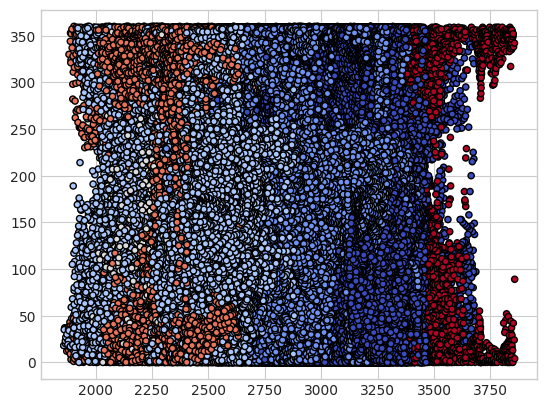

In [36]:
# 산림 토양 데이터셋에 대한 분포 시각화
plt.scatter(covtype_X[:, 0], covtype_X[:, 1], c=covtype_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

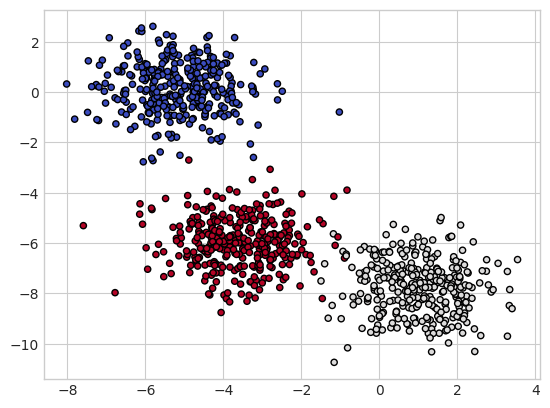

In [37]:
# 시각화를 위한 2차원 가상 데이터 생성 및 시각화

X, y = make_blobs(n_samples=1000)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [38]:
# 2차원 가상 데이터를 활용한 가우시안 나이브 베이즈 모델 생성 및 학습

model = GaussianNB()
model.fit(X, y)

GaussianNB()

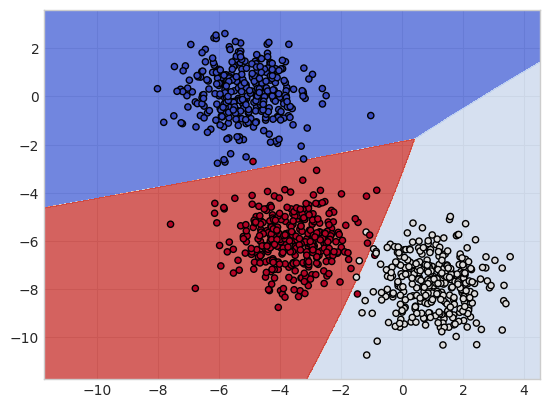

In [39]:
# 가상 데이터로 학습한 가우시안 나이브 베이즈 모델 결정경계 시각화

xx, yy = make_meshgrid(X[:, ], X[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

#### 베르누이 나이브 베이즈

* 입력 특성이 베르누이 분포에 의해 생성된 이진 값을 갖는 다고 가정

##### 학습 및 평가 (Count)

In [40]:
# 베르누이 Naive Bayes 모델 생성 및 벡터화(count vectorized)된 학습 데이터를 활용한 학습 진행

model = BernoulliNB()
model.fit(X_train_count, y_train)

BernoulliNB()

In [41]:
# 학습 데이터에 대한 예측 및 평가 수행

predict = model.predict(X_train_count)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print('CountVectorized Train Accuracy: {}'.format(acc))
print('CountVectorized Train F1 Score: {}'.format(f1))

CountVectorized Train Accuracy: 0.7821283365741559
CountVectorized Train F1 Score: [0.80096502 0.8538398  0.13858268 0.70686337 0.85220126 0.87944493
 0.51627694 0.84532672 0.89064976 0.87179487 0.94561404 0.91331546
 0.84627832 0.89825848 0.9047619  0.79242424 0.84693878 0.84489796
 0.67329545 0.14742015]


In [42]:
# 평가 데이터에 대한 예측 및 평가 수행

predict = model.predict(X_test_count)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('CountVectorized Test Accuracy: {}'.format(acc))
print('CountVectorized Test F1 Score: {}'.format(f1))

CountVectorized Test Accuracy: 0.6307753584705258
CountVectorized Test F1 Score: [0.47086247 0.60643564 0.01       0.56014047 0.6953405  0.70381232
 0.44829721 0.71878646 0.81797753 0.81893491 0.90287278 0.74794521
 0.61647059 0.64174455 0.76967096 0.63555114 0.64285714 0.77971474
 0.31382979 0.00793651]


##### 학습 및 평가 (Hash)

In [43]:
# 베르누이 Naive Bayes 모델 생성 및 벡터화(hash vectorized)된 학습 데이터를 활용한 학습 진행

model = BernoulliNB()
model.fit(X_train_hash, y_train)

BernoulliNB()

In [44]:
# 학습 데이터에 대한 예측 및 평가 수행

predict = model.predict(X_train_hash)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print('HashVectorized Train Accuracy: {}'.format(acc))
print('HashVectorized Train F1 Score: {}'.format(f1))

HashVectorized Train Accuracy: 0.5951917977726711
HashVectorized Train F1 Score: [0.74226804 0.49415205 0.45039019 0.59878155 0.57327935 0.63929619
 0.35390947 0.59851301 0.72695347 0.68123862 0.79809524 0.70532319
 0.54703833 0.66862745 0.61889927 0.74707471 0.6518668  0.60485269
 0.5324165  0.54576271]


In [45]:
# 평가 데이터에 대한 예측 및 평가 수행

predict = model.predict(X_test_hash)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('HashVectorized Test Accuracy: {}'.format(acc))
print('HashVectorized Test F1 Score: {}'.format(f1))

HashVectorized Test Accuracy: 0.4430430164630908
HashVectorized Test F1 Score: [0.46678636 0.33826638 0.29391892 0.45743329 0.41939121 0.46540881
 0.34440068 0.46464646 0.62849873 0.53038674 0.63782051 0.55251799
 0.32635983 0.34266886 0.46105919 0.61780105 0.46197991 0.54591837
 0.27513228 0.3307888 ]


##### 학습 및 평가 (Tf-idf)

In [46]:
# 베르누이 Naive Bayes 모델 생성 및 벡터화(TFIDF vectorized)된 학습 데이터를 활용한 학습 진행

model = BernoulliNB()
model.fit(X_train_tfidf, y_train)

BernoulliNB()

In [47]:
# 학습 데이터에 대한 예측 및 평가 수행

predict = model.predict(X_train_tfidf)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print('TFIDFVectorized Train Accuracy: {}'.format(acc))
print('TFIDFVectorized Train F1 Score: {}'.format(f1))

TFIDFVectorized Train Accuracy: 0.7821283365741559
TFIDFVectorized Train F1 Score: [0.80096502 0.8538398  0.13858268 0.70686337 0.85220126 0.87944493
 0.51627694 0.84532672 0.89064976 0.87179487 0.94561404 0.91331546
 0.84627832 0.89825848 0.9047619  0.79242424 0.84693878 0.84489796
 0.67329545 0.14742015]


In [48]:
# 평가 데이터에 대한 예측 및 평가 수행

predict = model.predict(X_test_tfidf)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('TFIDFVectorized Test Accuracy: {}'.format(acc))
print('TFIDFVectorized Test F1 Score: {}'.format(f1))

TFIDFVectorized Test Accuracy: 0.6307753584705258
TFIDFVectorized Test F1 Score: [0.47086247 0.60643564 0.01       0.56014047 0.6953405  0.70381232
 0.44829721 0.71878646 0.81797753 0.81893491 0.90287278 0.74794521
 0.61647059 0.64174455 0.76967096 0.63555114 0.64285714 0.77971474
 0.31382979 0.00793651]


#### 다항 나이브 베이즈

* 입력 특성이 다항분포에 의해 생성된 빈도수 값을 갖는 다고 가정

##### 학습 및 평가 (Count)

In [49]:
# Multinomial Naive Bayes 모델 생성 및 벡터화(count vectorized)된 학습 데이터를 활용한 학습 진행

model = MultinomialNB()
model.fit(X_train_count, y_train)

MultinomialNB()

In [50]:
# 학습 데이터에 대한 예측 및 평가 수행

predict = model.predict(X_train_count)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print('Train Accuracy: {}'.format(acc))
print('Train F1 Score: {}'.format(f1))

Train Accuracy: 0.9245182959165635
Train F1 Score: [0.95228426 0.904      0.25073746 0.81402003 0.96669513 0.88350983
 0.90710383 0.97014925 0.98567818 0.99325464 0.98423237 0.95399516
 0.95703454 0.98319328 0.98584513 0.95352564 0.97307002 0.97467249
 0.95157895 0.86526946]


In [51]:
# 평가 데이터에 대한 예측 및 평가 수행

predict = model.predict(X_test_count)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('Test Accuracy: {}'.format(acc))
print('Test F1 Score: {}'.format(f1))

Test Accuracy: 0.7728359001593202
Test F1 Score: [0.77901431 0.7008547  0.00501253 0.64516129 0.79178082 0.73370166
 0.76550681 0.88779285 0.93951094 0.91390728 0.94594595 0.78459938
 0.72299169 0.84635417 0.86029412 0.80846561 0.78665077 0.89281211
 0.60465116 0.48695652]


##### 학습 및 평가 (Hash)
* Hash 벡터화 과정에서 음수 값이 섞여 Hash Vectorizer를 사용하기엔 부적절

##### 학습 및 평가 (Tf-idf)

In [52]:
# Multinomial Naive Bayes 모델 생성 및 벡터화(TFIDF vectorized)된 학습 데이터를 활용한 학습 진행

model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [53]:
# 학습 데이터에 대한 예측 및 평가 수행

predict = model.predict(X_train_tfidf)
acc = metrics.accuracy_score(y_train, predict)
f1 = metrics.f1_score(y_train, predict, average=None)

print('Train Accuracy: {}'.format(acc))
print('Train F1 Score: {}'.format(f1))

Train Accuracy: 0.9326498143892522
Train F1 Score: [0.87404162 0.95414462 0.95726496 0.92863002 0.97812773 0.97440273
 0.91090909 0.97261411 0.98659966 0.98575021 0.98026316 0.94033413
 0.9594478  0.98032506 0.97755611 0.77411003 0.93506494 0.97453907
 0.90163934 0.45081967]


In [54]:
# 평가 데이터에 대한 예측 및 평가 수행

predict = model.predict(X_test_tfidf)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('Test Accuracy: {}'.format(acc))
print('Test F1 Score: {}'.format(f1))

Test Accuracy: 0.7738980350504514
Test F1 Score: [0.63117871 0.72       0.72778561 0.72104019 0.81309686 0.81643836
 0.7958884  0.88135593 0.93450882 0.91071429 0.92917167 0.73583093
 0.69732938 0.81907433 0.86559803 0.60728118 0.76286353 0.92225201
 0.57977528 0.24390244]


##### Bernoulli VS Multinomial

In [55]:
# 다항 나이브 베이즈 모델 실험을 위한 2차원 가상 데이터 생성 및 시각화
# 다항 나이브 베이즈 모델은 음수 값을 받을 수 없기 때문에 MinMax Scaling을 통해 음수값 제거

X, y = make_blobs(n_samples=1000)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

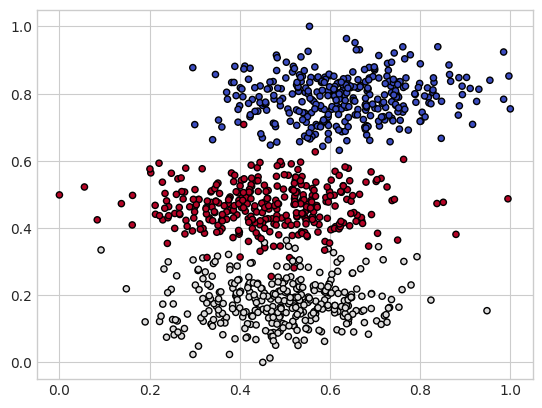

In [56]:
# 생성된 2차원 가상 데이터 시각화

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [57]:
# 다항 나이브 vs 베르누이 비교 분석을 위한 베르누이 학습 및 시각화

model = BernoulliNB()
model.fit(X, y)

BernoulliNB()

In [58]:
# 베르누이 모델을 활용한 예측 및 평가

predict = model.predict(X)
acc = metrics.accuracy_score(y, predict)
f1 = metrics.f1_score(y, predict, average=None)

print('Bernoulli Test Accuracy: {}'.format(acc))
print('Bernoulli Test F1 Score: {}'.format(f1))

Bernoulli Test Accuracy: 0.336
Bernoulli Test F1 Score: [0.5015015  0.00598802 0.00598802]


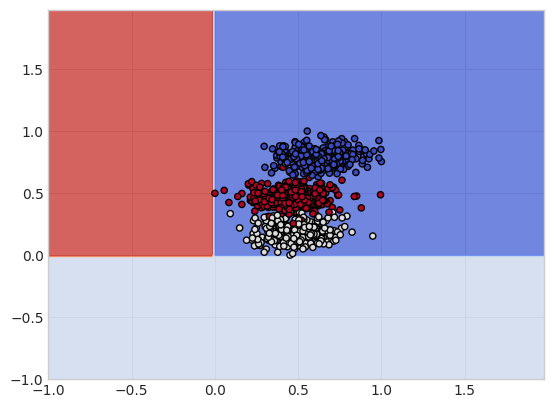

In [59]:
xx, yy = make_meshgrid(X[:, 0], X[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [60]:
# 다항 모델 학습 및 시각화

model = MultinomialNB()
model.fit(X, y)

MultinomialNB()

In [61]:
# 다항 모델을 활용한 예측 및 평가

predict = model.predict(X)
acc = metrics.accuracy_score(y, predict)
f1 = metrics.f1_score(y, predict, average=None)

print('Multinomial Test Accuracy: {}'.format(acc))
print('Multinomial Test F1 Score: {}'.format(f1))

Multinomial Test Accuracy: 0.722
Multinomial Test F1 Score: [0.68392371 0.92068429 0.56179775]


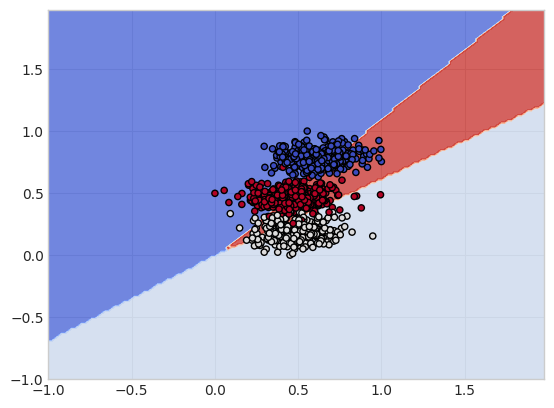

In [62]:
xx, yy = make_meshgrid(X[:, 0], X[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')